In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import bz2
# or: requests.get(url).content

#myzip = ZipFile(BytesIO(resp.read()))
##resp = urlopen("http://www.test.com/file.zip")
#for line in myzip.open(file).readlines():
#    print(line.decode('utf-8'))

In [5]:
interactions_url = 'https://zenodo.org/record/6609677/files/userid_trackid_timestamp.tsv.bz2?download=1'

compressed = requests.get(interactions_url).content

data = bz2.decompress(compressed)

open('userid_trackid_timestamp.tsv', 'wb').write(data)

11089302261

In [6]:
def get_dataset_stats(data, listen_cap, play_cap):

    user_actions = data.groupby(['user_id']).count()['track_id']
    item_plays = data.groupby(['track_id']).count()['user_id']

    num_users = len(data['user_id'].unique())
    num_tracks = len(data['track_id'].unique())

    unique_actions = data[['user_id', 'track_id']].drop_duplicates()

    unique_sparsity = 100 * (1 - round( (len(unique_actions)/(num_users * num_tracks)) , 4))
    sparsity = 100 * (1 - round( (len(data)/(num_users * num_tracks)) , 4))

    #------------------------------------------------------------------------------
    """
    print(f'''
    Interactions: {len(data)}
    Unique Interactions: {len(unique_actions)}
    Num Users: {num_users}
    Num Tracks: {num_tracks}
    Earliest Interaction: {max(data.timestamp)}
    Latest Interaction: {min(data.timestamp)}
    
    There are {len(user_actions)} users.
    There are {sum(user_actions<listen_cap)} users with less than {listen_cap} listens
    Each user has an average of {int(np.mean(user_actions))} listens.

    There are {len(item_plays)} tracks.
    Each track has an average of {int(np.mean(item_plays))} plays.
    Unique Interaction Data Sparsity: {unique_sparsity}%
    Sparsity with Repeated Interactions: {sparsity}%

    ''')
    """

    #------------------------------------------------------------------------------
    # MAIN STATISTICS

    size = len(data)

    if size < 10**6:
        print(f'\nMusic4All {len(data)//10**3}K Interactions Stats')
    else:
        print(f'\nMusic4All {len(data)//10**6}M Interactions Stats')
        

    print(f'''
    |Users\t| Items\t\t| Interactions\t| Average Length\t| Median Length\t| Sparsity\t|
    -----------------------------------------------------------------------------------------------------
    |{num_users}  \t| {num_tracks}\t\t| {len(data)}\t| {np.mean(user_actions).astype(int)}\t\t\t| {np.median(user_actions).astype(int)}\t\t| {round(unique_sparsity,2)}\t\t|
    
    ''')

def read_music4all(chunksize=False, listen_cap=100, play_cap=100):

    if chunksize:
        for chunk in pd.read_csv('userid_trackid_timestamp.tsv', sep='\t', chunksize=chunksize, parse_dates=True):
            get_dataset_stats(chunk, listen_cap, play_cap)
            return chunk
    else:
        data = pd.read_csv('userid_trackid_timestamp.tsv', sep='\t', parse_dates=True)
        get_dataset_stats(data, listen_cap, play_cap)
        return data

def format_for_recbole(data):

    new_data = data.copy()
    new_data.timestamp = pd.to_datetime(data.timestamp).astype(int) / 10**9
    new_data.columns = ['user_id:token', 'track_id:token', 'timestamp:float']

    size = len(new_data)
    if size < 10**6:
        new_data.to_csv(f'datasets/music4all_{size//10**3}k.inter' ,sep='\t', index=False)
        new_data['user_id:token'].to_csv(f'datasets/music4all_{size//10**3}k.user' ,sep='\t', index=False)
        new_data['track_id:token'].to_csv(f'datasets/music4all_{size//10**3}k.item' ,sep='\t', index=False)
    else:
        new_data.to_csv(f'datasets/music4all_{size//10**6}M.inter' ,sep='\t', index=False)
        new_data['user_id:token'].to_csv(f'datasets/music4all_{size//10**6}M.user' ,sep='\t', index=False)
        new_data['track_id:token'].to_csv(f'datasets/music4all_{size//10**6}M.item' ,sep='\t', index=False)
    
#data = read_music4all(chunksize=10**5, listen_cap=100, play_cap=100)
#format_for_recbole(data)

#data = read_music4all(chunksize=10**6, listen_cap=100, play_cap=100)
#format_for_recbole(data)

#data = read_music4all(chunksize=10**7, listen_cap=100, play_cap=100)
#format_for_recbole(data)

#data = read_music4all(chunksize=10**8, listen_cap=100, play_cap=100)
#format_for_recbole(data)

data = read_music4all(chunksize=10**4)
format_for_recbole(data)


Music4All 10K Interactions Stats

    |Users	| Items		| Interactions	| Average Length	| Median Length	| Sparsity	|
    -----------------------------------------------------------------------------------------------------
    |17  	| 2512		| 10000	| 588			| 370		| 93.37		|
    
    


OSError: Cannot save file into a non-existent directory: 'datasets'

KeyboardInterrupt: 

In [78]:
def remove_coldstart(data, min_interactions):

    user_counts = data[['user_id', 'track_id']].groupby(['user_id']).count()

    cold_start_users = user_counts < min_interactions

    user_id, cold_start = np.array(cold_start_users.index), np.array(cold_start_users.track_id)

    normal_user_id = user_id[np.invert(cold_start)]

    print(f'There are {sum(cold_start)} users with less than {min_interactions} interactions')

    new_data = data[data.user_id.isin(normal_user_id)]


no_coldstart_df = remove_coldstart(data, 5)

There are 5 users with less than 5 interactions


---

In [71]:
user_action_counts = list(user_actions) #.plot.hist()

user_action_stats = user_actions.quantile([0.25, 0.5, 0.75])

print(user_action_stats, np.mean(user_action_counts))

#plt.hist(user_action_counts, bins=100, log=True)

# Calculate the 95% confidence for listen counts per user.

mean, std = np.mean(user_action_counts), np.std(user_action_counts)
n = len(user_actions)

print(mean, std)

confidence_interval = [mean - 0.95*(std/np.sqrt(n)), mean + 0.95*(std/np.sqrt(n))]
confidence_interval

plt.hist(user_action_counts, bins=100)
plt.xlabel('Users')
plt.ylabel('Interactions')
plt.semilogy()

NameError: name 'user_actions' is not defined

In [10]:
print(item_plays.values)

[4859 3244 6060 ... 1657 3503 5168]


0.25     628.00
0.50    1896.00
0.75    4962.25
Name: user_id, dtype: float64


[]

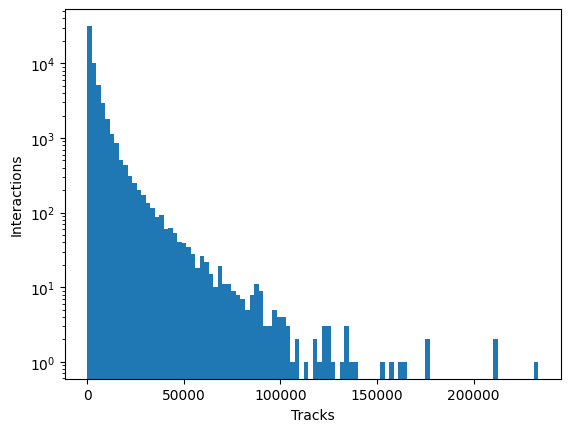

In [20]:
item_play_counts = list(item_plays.values) #.plot.hist()

item_play_stats = item_plays.quantile([0.25, 0.5, 0.75])

print(item_play_stats)

plt.hist(item_play_counts, bins=100)
plt.xlabel('Tracks')
plt.ylabel('Interactions')
plt.semilogy()

In [ ]:
interaction_count.head()

In [ ]:
interactions.head()